In [1]:
#import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [2]:
# Step 1: Load the MovieLens 100k dataset
# Load data and label data as dataframe in ways that the user can make sense. Each file was investigated to find the separator
#and the labels for the columns
ratings = pd.read_csv('/workspaces/Big_Data_2024/ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
users = pd.read_csv('/workspaces/Big_Data_2024/ml-100k/u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
movies = pd.read_csv('/workspaces/Big_Data_2024/ml-100k/u.item', sep='|', encoding='latin-1', names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL'] + [f'genre_{i}' for i in range(19)])
occupation= pd.read_csv('/workspaces/Big_Data_2024/ml-100k/u.occupation', sep='|', names=['occupation_name'])
infos= pd.read_csv('/workspaces/Big_Data_2024/ml-100k/u.info', sep='|', names=['number', 'info'])
genre= pd.read_csv('/workspaces/Big_Data_2024/ml-100k/u.genre', sep='|', names=['movie_type', 'type_id'])

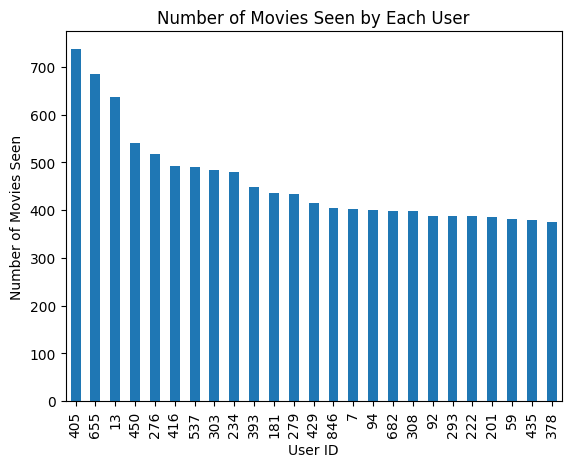

In [3]:
#Step 2
# Basic Descriptive Statistics
# Plot number of movies seen by each user
user_movie_counts = ratings['user_id'].value_counts().head(25)
# head(25) to plot the top 25, because the chart was too crowded, this shows us the top users
plt.figure()
user_movie_counts.plot(kind='bar')
plt.xlabel('User ID')
plt.ylabel('Number of Movies Seen')
plt.title('Number of Movies Seen by Each User')
plt.show()

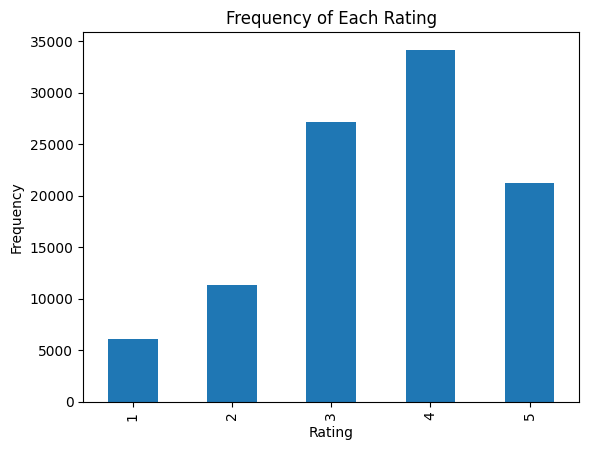

In [4]:
# Plot the frequency of each rating
rating_counts = ratings['rating'].value_counts().sort_index()
plt.figure()
rating_counts.plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Frequency of Each Rating')
plt.show()

In [5]:
#More descriptive statistics of the data sets, to understand the spread of the data further and make an informed decision
#on the outliers

# Mean, median, and standard deviation of movies seen by each user
#count of the number of time each unique user id appears in column 
user_movie_counts = ratings['user_id'].value_counts()
#statistics of the user movie counts
mean_movies_rated = user_movie_counts.mean()
median_movies_rated = user_movie_counts.median()
std_movies_rated = user_movie_counts.std()
Q3_movies_rated = user_movie_counts.quantile(0.75)
# Largest (maximum) number of movies rated by a user
max_movies_rated = user_movie_counts.max()
# Smallest (minimum) number of movies rated by a user
min_movies_rated = user_movie_counts.min()

# Creating a summary table to visualize the results
summary_table = pd.DataFrame({
    'Statistic': ['Mean', 'Median', 'Top Quartile','Standard Deviation', 'Minimum', 'Maximum'],
    'Movies Rated by User': [mean_movies_rated, median_movies_rated, Q3_movies_rated, std_movies_rated, max_movies_rated, min_movies_rated]
})

# Display the table
print(summary_table.round(1))

from scipy.stats import percentileofscore
#We want to see what percentage of the values are above 1.5 standard deviations of the mean which is 106 + 151.35. round to nearest whole number
value = 257
# Calculate the percentile of this value within the distribution of movie counts
percentile = percentileofscore(user_movie_counts, value, kind='rank')

print(f"The percentile rank of rating 257 movies is: {percentile.round(2)}%")

            Statistic  Movies Rated by User
0                Mean                 106.0
1              Median                  65.0
2        Top Quartile                 148.0
3  Standard Deviation                 100.9
4             Minimum                 737.0
5             Maximum                  20.0
The percentile rank of rating 257 movies is: 90.67%


In [ ]:
#More descriptive statistics of the data sets, to understand the spread of the data further and make an informed decision
#on the outliers

# Mean, median, and standard deviation of ratings recieved for each movie
#count of the number of time each movie (item) appears in column 
movie_rating_counts = ratings['item_id'].value_counts()
#statistics of the movie ratings counts
mean_ratings_received = movie_rating_counts.mean()
median_ratings_received = movie_rating_counts.median()
std_ratings_received = movie_rating_counts.std()
Q3_ratings_received = movie_rating_counts.quantile(0.75)
# Largest (maximum) number of ratings for a movie
max_ratings_received = movie_rating_counts.max()
# Smallest (minimum) number of ratings for a movie
min_ratings_received = movie_rating_counts.min()

# Creating a summary table to visualize the results
summary_table2 = pd.DataFrame({
    'Statistic': ['Mean', 'Median', 'Top Quartile','Standard Deviation', 'Minimum', 'Maximum'],
    'Ratings Received for Each Movie': [mean_ratings_received, median_ratings_received, Q3_ratings_received, std_ratings_received, max_ratings_received, min_ratings_received]
})

# Display the table
print(summary_table2.round(1))

#We want to see what percentage of the values are above 1.5 standard deviations of the mean which is 59.5 + 120.6. round to nearest whole number
value = 180
# Calculate the percentile of this value within the distribution of movie rating counts
percentile2 = percentileofscore(movie_rating_counts, value, kind='rank')

print(f"The percentile rank of 180 ratings is: {percentile2.round(2)}%")

# we decide to do 1.5 standard deviations for this dataset as well

            Statistic  Ratings Received for Each Movie
0                Mean                             59.5
1              Median                             27.0
2        Top Quartile                             80.0
3  Standard Deviation                             80.4
4             Minimum                            583.0
5             Maximum                              1.0
The percentile rank of 180 ratings is: 91.8%


In [14]:
# Outlier Detection for Users and Movies with a 1.5 Standard Deviation Threshold
# choosing 1.5 for the outlier threshold because ~91% of users are concentrated below 1.5 standard deviation of the mean.

#We have user_movie_counts as data of how many movies each user has rated
# Step 1: Calculate the number of ratings each movie has received
movie_rating_counts = ratings['item_id'].value_counts()

# Step 3: Calculate z-scores for user and movie counts to detect outliers
user_movie_counts_zscore = zscore(user_movie_counts)
movie_rating_counts_zscore = zscore(movie_rating_counts)

# Step 4: Set a threshold of 1.5 standard deviations for detecting outliers
outlier_user_indices = user_movie_counts[user_movie_counts_zscore > 1.5].index
outlier_movie_indices = movie_rating_counts[movie_rating_counts_zscore > 1.5].index

# Outlier users: those who have rated more than 1.5 standard deviations above the mean aka more than ~257 movies or a movie with more than ~180
outlier_users = user_movie_counts[user_movie_counts_zscore > 1.5]
#print("Outlier users based on number of ratings (Threshold = 1.5 SD):")
#print(outlier_users)

# Outlier movies: those that have received more than 1.5 standard deviations above the mean
outlier_movies = movie_rating_counts[movie_rating_counts_zscore > 1.5]
#print("\nOutlier movies based on number of ratings (Threshold = 1.5 SD):")
#print(outlier_movies)


In [20]:
# Convert the data to a user-item matrix format
user_movie_ratings_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating')

# Display the user-item matrix
print("User-Movie Matrix:")
print(user_movie_ratings_matrix.head(15))

# Save the user-item matrix to a CSV file to investigate if it was correct
user_movie_ratings_matrix.to_csv('user_movie_ratings_matrix.csv')


User-Movie Matrix:
item_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                              ...   
1         5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0  ...   
2         4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   2.0  ...   
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5         4.0   3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
6         4.0   NaN   NaN   NaN   NaN   NaN   2.0   4.0   4.0   NaN  ...   
7         NaN   NaN   NaN   5.0   NaN   NaN   5.0   5.0   5.0   4.0  ...   
8         NaN   NaN   NaN   NaN   NaN   NaN   3.0   NaN   NaN   NaN  ...   
9         NaN   NaN   NaN   NaN   NaN   5.0   4.0   NaN   NaN   NaN  ...   
10        4.0   NaN   NaN   4.0   NaN   NaN   4.0   NaN   4.0   NaN  ...   
11        NaN   NaN   NaN   NaN   NaN   NaN   NaN   4.0   5.0   NaN  